# Giliad and Nvo - Ratio spread, no residual no Kalman

### Entry Threshold:	2.50	Exit Threshold:	0.20 | Max Duration:	25 days |	

### MA Period:	30	SMA	| StdDev Period:	30 | RSI Period:	14	RSI Threshold:	0 | 		


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import statsmodels
from pandas_datareader import data
import datetime
import quandl
from statsmodels.tsa.stattools import adfuller

In [2]:
start= datetime.datetime(2017, 1, 1)  # The start of the year for example
end= datetime.datetime(2020, 9, 30)

In [3]:
ticker_1 = "gild"
ticker_2 = "nvo"

In [4]:
df_tickr1 = data.DataReader(name= ticker_1, data_source= "yahoo", start= start, end= end)
df_tickr2 = data.DataReader(name= ticker_2, data_source= "yahoo", start= start, end= end)

In [5]:
df_tickr1.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-26,67.650002,66.680000,66.970001,67.279999,6923500.0,67.279999
2019-11-27,67.489998,66.699997,67.279999,67.120003,4980300.0,67.120003
2019-11-29,67.360001,66.809998,67.040001,67.239998,2658800.0,67.239998
2019-12-02,67.519997,65.940002,67.250000,66.120003,7642100.0,66.120003
2019-12-03,66.197998,65.180000,65.790001,66.070000,4919902.0,66.070000


In [6]:
df_tickr2.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-26,56.430000,55.970001,56.080002,56.250000,983000.0,56.250000
2019-11-27,56.509998,56.029999,56.040001,56.360001,1779600.0,56.360001
2019-11-29,56.520000,56.040001,56.470001,56.150002,547100.0,56.150002
2019-12-02,56.160000,55.689999,56.020000,56.020000,831300.0,56.020000
2019-12-03,56.580002,56.259998,56.330002,56.520000,1659549.0,56.520000


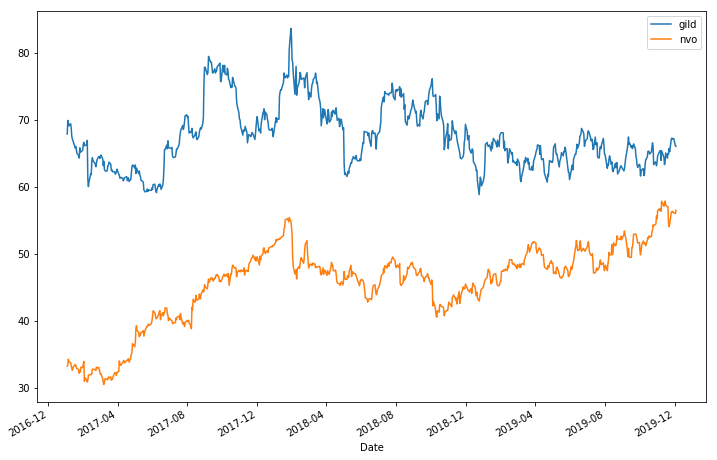

In [7]:
df_tickr1['Adj Close'].plot(label='{}'.format(ticker_1),figsize=(12,8))
df_tickr2['Adj Close'].plot(label='{}'.format(ticker_2))
plt.legend();

In [8]:
spread_ratio = df_tickr1['Adj Close']/df_tickr2['Adj Close']

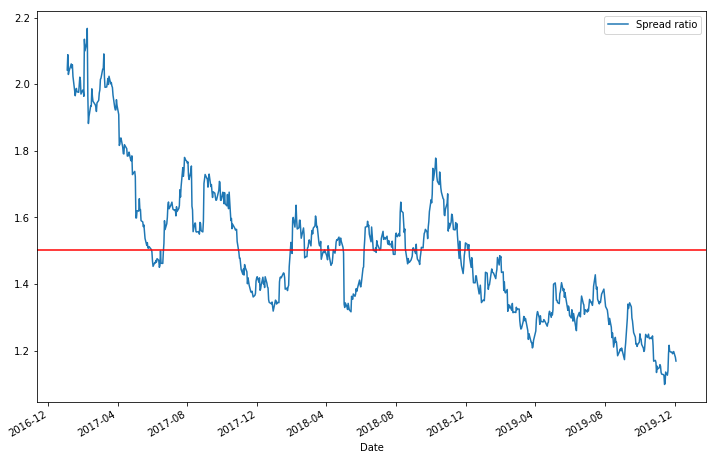

In [9]:
spread_ratio.plot(label='Spread ratio',figsize=(12,8))
plt.axhline(spread_ratio.mean(),c='r')
plt.legend();

In [10]:
def zscore(stocks):
    return (stocks - stocks.mean()) / np.std(stocks)

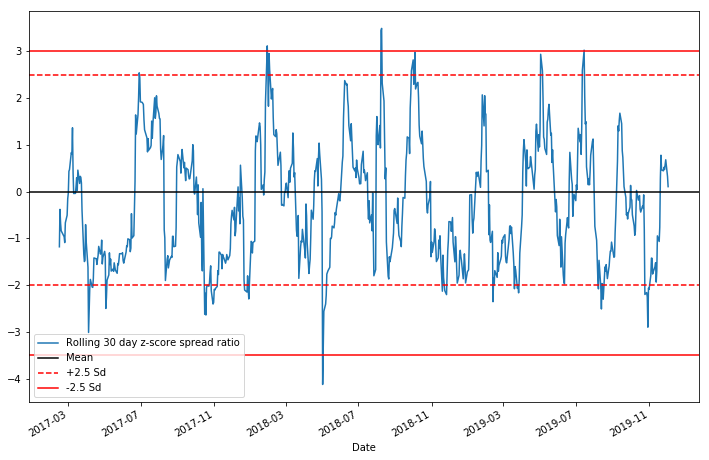

In [11]:
#1 day moving average of the price spread
spreadratio_mavg1 = spread_ratio.rolling(1).mean()

# 30 day moving average of the price spread
spreadratio_mavg30 = spread_ratio.rolling(30).mean()

# Take a rolling 30 day standard deviation
std_30ratio = spread_ratio.rolling(30).std()

# Compute the z score for each day
zscore_30_1_ratio = (spreadratio_mavg1 - spreadratio_mavg30)/std_30ratio



zscore_30_1_ratio.plot(figsize=(12,8),label='Rolling 30 day Z score for spread ratio')
plt.axhline(0, color='black')
plt.axhline(2.5, color='red', linestyle='--')
plt.axhline(3.0, color='red', linestyle='-')
plt.axhline(-3.5, color='red', linestyle='-')
plt.axhline(-2.0, color='red',linestyle='--')
plt.legend(['Rolling 30 day z-score spread ratio', 'Mean', '+2.5 Sd', '-2.5 Sd']);

In [12]:
from statsmodels.tsa.stattools import coint

In [13]:
y0 = df_tickr1['Adj Close']
y1 = df_tickr2['Adj Close']

In [14]:
t_stat_summary = statsmodels.tsa.stattools.coint(y0, y1, trend='c', method='aeg', maxlag=None, autolag='aic', return_results=True) 

In [15]:
print('----------------------------------------')
print('T-stat for the pair {} VS {}:'.format(ticker_1,ticker_2), t_stat_summary[0])
print('Alpha value for the T-stat:  {}'.format(t_stat_summary[1]))
print('--------------------------------------')
print('T-stat 99%:  {}'.format(t_stat_summary[2][0]))
print('T-stat 95%:  {}'.format(t_stat_summary[2][1]))
print('T-stat 90%:  {}'.format(t_stat_summary[2][2]))

----------------------------------------
T-stat for the pair gild VS nvo: -2.8720464729693735
Alpha value for the T-stat:  0.14383365002339477
--------------------------------------
T-stat 99%:  -3.9114230750840826
T-stat 95%:  -3.3444670512810992
T-stat 90%:  -3.050233250302549


In [16]:
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
    print("Dickey Fuller Confidence Intervals:  ", adfuller(spread_ratio)[4])

adf_check(spread_ratio)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.3027727616337637
p-value : 0.1710752601556224
#Lags Used : 0
Number of Observations Used : 734
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
Dickey Fuller Confidence Intervals:   {'1%': -3.439290485895927, '5%': -2.8654856985173414, '10%': -2.568871126669587}


In [17]:
np.corrcoef(df_tickr1['Adj Close'],df_tickr2['Adj Close'])

array([[1.       , 0.2719818],
       [0.2719818, 1.       ]])

In [18]:
np.cov(df_tickr1['Adj Close'],df_tickr2['Adj Close'])

array([[23.30264299,  7.83914596],
       [ 7.83914596, 35.64943335]])

In [19]:
zscore_30_1_ratio[-30:]

Date
2019-10-22   -0.346382
2019-10-23   -0.070549
2019-10-24   -0.820463
2019-10-25   -2.198004
2019-10-28   -2.157834
2019-10-29   -2.250622
2019-10-30   -2.897367
2019-10-31   -2.064635
2019-11-01   -2.090282
2019-11-04   -1.786630
2019-11-05   -1.420776
2019-11-06   -1.426534
2019-11-07   -1.761920
2019-11-08   -1.716025
2019-11-11   -1.604494
2019-11-12   -1.521420
2019-11-13   -1.934179
2019-11-14   -1.699635
2019-11-15   -0.946391
2019-11-18   -1.066493
2019-11-19   -0.761285
2019-11-20    0.271186
2019-11-21    0.776490
2019-11-22    0.466636
2019-11-25    0.442171
2019-11-26    0.517722
2019-11-27    0.470102
2019-11-29    0.679223
2019-12-02    0.324455
2019-12-03    0.104989
Name: Adj Close, dtype: float64

In [20]:
spread_ratio[-20:]

Date
2019-11-05    1.158165
2019-11-06    1.153819
2019-11-07    1.134646
2019-11-08    1.129774
2019-11-11    1.128295
2019-11-12    1.126642
2019-11-13    1.098716
2019-11-14    1.102263
2019-11-15    1.135999
2019-11-18    1.126511
2019-11-19    1.139551
2019-11-20    1.191333
2019-11-21    1.216321
2019-11-22    1.198311
2019-11-25    1.195022
2019-11-26    1.196089
2019-11-27    1.190916
2019-11-29    1.197507
2019-12-02    1.180293
2019-12-03    1.168967
Name: Adj Close, dtype: float64

In [21]:
#differenced spread
t_series_lag_1 = spread_ratio.diff(1)

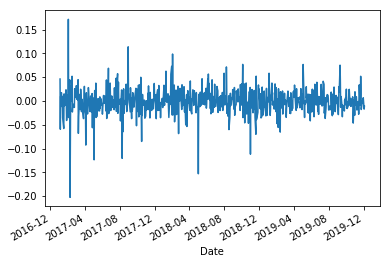

In [22]:
t_series_lag_1.plot()

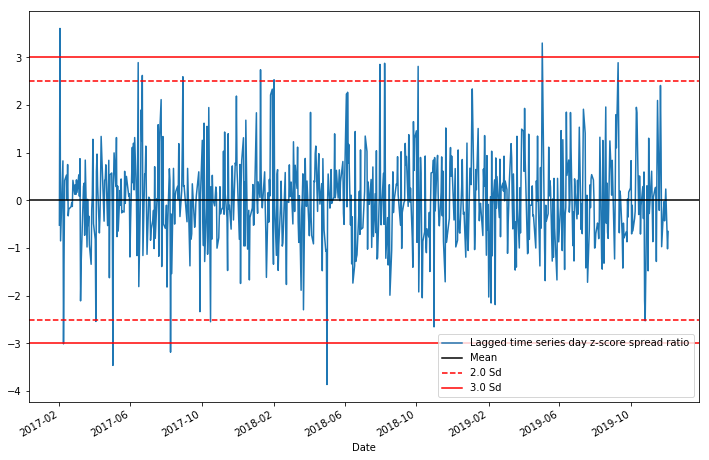

In [23]:
#1 day moving average of the price spread
spreadratio_t_series_lag_mavg_1 = t_series_lag_1.rolling(1).mean()

# Timeseries with one lag
spreadratio_t_series_lag_mavg_30 = t_series_lag_1.rolling(20).mean()

# Take a rolling 30 day standard deviation
std_dev_ratio = t_series_lag_1.rolling(20).std()

# Compute the z score for each day
zscore_t_series_lag = (spreadratio_t_series_lag_mavg_1 - spreadratio_t_series_lag_mavg_30)/std_dev_ratio



zscore_t_series_lag.plot(figsize=(12,8),label='Timeseries Lagged 1 day Z score for spread ratio')
plt.axhline(0, color='black')
plt.axhline(2.5, color='red', linestyle='--')
plt.axhline(3.0, color='red', linestyle='-')
plt.axhline(-3.0, color='red', linestyle='-')
plt.axhline(-2.5, color='red',linestyle='--')
plt.legend(['Lagged time series day z-score spread ratio', 'Mean', '2.0 Sd', '3.0 Sd']);

In [24]:
t_series_lag_1[-20:]

Date
2019-11-05    0.008888
2019-11-06   -0.004346
2019-11-07   -0.019173
2019-11-08   -0.004872
2019-11-11   -0.001479
2019-11-12   -0.001652
2019-11-13   -0.027926
2019-11-14    0.003547
2019-11-15    0.033736
2019-11-18   -0.009487
2019-11-19    0.013040
2019-11-20    0.051782
2019-11-21    0.024988
2019-11-22   -0.018011
2019-11-25   -0.003289
2019-11-26    0.001067
2019-11-27   -0.005173
2019-11-29    0.006591
2019-12-02   -0.017214
2019-12-03   -0.011326
Name: Adj Close, dtype: float64

In [25]:
statsmodels.tsa.stattools.adfuller(spread_ratio, maxlag= None, regression='c', autolag='t-stat', store=False, regresults=False)

(-2.0962385325949415,
 0.2460297940431661,
 20,
 714,
 {'1%': -3.4395418285955563,
  '5%': -2.865596454500293,
  '10%': -2.5689301318958955},
 1.725994514526026)